# Pytorch implementation with pretrained model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np


In [3]:
mean = np.array([0.48, 0.49, 0.485])
std = np.array([0.24, 0.25, 0.24])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [4]:
data_dir = 'output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(class_names)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [ ]:
print(device)

cuda


In [ ]:
from os import path
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp) 
    if title is not None:  
       # plt.savefig(path.join('/content/',"dataname_{0}.png".format(title)))
        plt.title(title)
           
    plt.show()

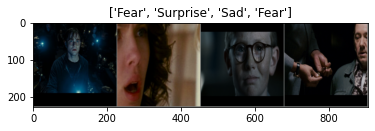

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20,device='cpu'):
    since = time.time()
    epoch_loss1 = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max((outputs), 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_loss1.append([phase, epoch_loss, epoch_acc])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,epoch_loss1

In [ ]:
import torchvision.models.quantization as models

# You will need the number of filters in the `fc` for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet50(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

In [ ]:
from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(    
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 7),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model

In [ ]:
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
#new_model.to('cpu')
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25,device='cpu')

Epoch 0/24
----------
train Loss: 7.8066 Acc: 0.1574
val Loss: 7.4586 Acc: 0.2090
Epoch 1/24
----------
train Loss: 9.1541 Acc: 0.2241
val Loss: 7.8655 Acc: 0.1791
Epoch 2/24
----------
train Loss: 9.9475 Acc: 0.2370
val Loss: 10.2855 Acc: 0.2239
Epoch 3/24
----------
train Loss: 10.9517 Acc: 0.2481
val Loss: 7.2996 Acc: 0.2687
Epoch 4/24
----------
train Loss: 10.0675 Acc: 0.2648
val Loss: 8.2880 Acc: 0.2836
Epoch 5/24
----------
train Loss: 11.2583 Acc: 0.2648
val Loss: 8.7693 Acc: 0.2687
Epoch 6/24
----------
train Loss: 11.1254 Acc: 0.2667
val Loss: 11.8888 Acc: 0.2985
Epoch 7/24
----------
train Loss: 8.7645 Acc: 0.3352
val Loss: 6.4740 Acc: 0.3731
Epoch 8/24
----------
train Loss: 7.7370 Acc: 0.3370
val Loss: 6.2001 Acc: 0.3881
Epoch 9/24
----------
train Loss: 7.0173 Acc: 0.3574
val Loss: 6.1355 Acc: 0.3284
Epoch 10/24
----------
train Loss: 6.7792 Acc: 0.3537
val Loss: 5.9847 Acc: 0.3731
Epoch 11/24
----------
train Loss: 7.0151 Acc: 0.3315
val Loss: 5.9604 Acc: 0.3433
Epoch 12

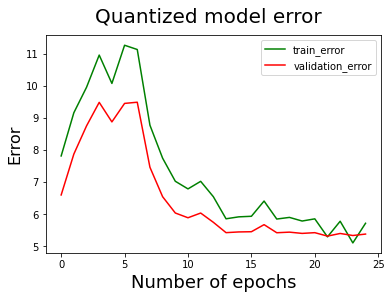

In [ ]:
new_model[1]
val_loss = []
train_loss = []
for k in new_model[1]:
  if k[0] == 'train':
    train_loss.append(k[1])
  if k[0] == 'val':
    val_loss.append(k[1])

import numpy as np
import matplotlib.pyplot as plt
poly = np.polyfit(train_loss,val_loss,5)
poly_y = np.poly1d(poly)(train_loss)
plt.plot(train_loss,'g',label= 'train_error')
plt.plot(poly_y,'r',label= 'validation_error')
plt.suptitle('Quantized model error', fontsize=20)
plt.xlabel('Number of epochs', fontsize=18)
plt.ylabel('Error', fontsize=16)
plt.legend()
plt.savefig("pre.png")
plt.show()

In [ ]:
model = models.resnet50(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

model.train() 
model.fuse_model()

model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig 

model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
for param in model_ft.parameters():
  param.requires_grad = True

model_ft.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                             num_epochs=25, device=device)

Epoch 0/24
----------
train Loss: 2.1342 Acc: 0.1759
val Loss: 1.9495 Acc: 0.1791
Epoch 1/24
----------
train Loss: 1.9961 Acc: 0.2352
val Loss: 2.0091 Acc: 0.2537
Epoch 2/24
----------
train Loss: 1.8939 Acc: 0.2870
val Loss: 1.7800 Acc: 0.3433
Epoch 3/24
----------
train Loss: 1.8048 Acc: 0.3074
val Loss: 1.7711 Acc: 0.3284
Epoch 4/24
----------
train Loss: 1.8149 Acc: 0.2944
val Loss: 1.7710 Acc: 0.3433
Epoch 5/24
----------
train Loss: 1.6901 Acc: 0.3574
val Loss: 1.5922 Acc: 0.3731
Epoch 6/24
----------
train Loss: 1.5451 Acc: 0.4370
val Loss: 1.7274 Acc: 0.4328
Epoch 7/24
----------
train Loss: 1.4788 Acc: 0.4907
val Loss: 1.5552 Acc: 0.4328
Epoch 8/24
----------
train Loss: 1.4021 Acc: 0.5000
val Loss: 1.6819 Acc: 0.3881
Epoch 9/24
----------
train Loss: 1.3501 Acc: 0.5389
val Loss: 1.6797 Acc: 0.4328
Epoch 10/24
----------
train Loss: 1.2949 Acc: 0.5796
val Loss: 1.6337 Acc: 0.4179
Epoch 11/24
----------
train Loss: 1.2369 Acc: 0.6019
val Loss: 1.5990 Acc: 0.4627
Epoch 12/24
--

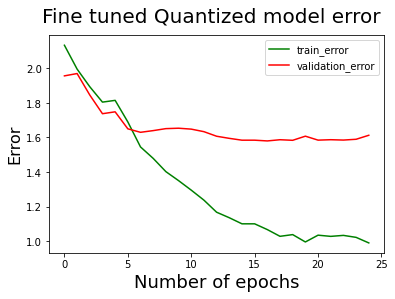

In [ ]:
#model_ft_tuned[1]
val_loss = []
train_loss = []
for k in model_ft_tuned[1]:
  if k[0] == 'train':
    train_loss.append(k[1])
  if k[0] == 'val':
    val_loss.append(k[1])

import numpy as np
import matplotlib.pyplot as plt
poly = np.polyfit(train_loss,val_loss,5)
poly_y = np.poly1d(poly)(train_loss)
plt.plot(train_loss,'g',label= 'train_error')
plt.plot(poly_y,'r',label= 'validation_error')
plt.suptitle('Fine tuned Quantized model error', fontsize=20)
plt.xlabel('Number of epochs', fontsize=18)
plt.ylabel('Error', fontsize=16)
plt.legend()
plt.savefig("pre1.png")
plt.show()

In [ ]:
from torch.quantization import convert
model = model_ft_tuned[0].cpu()

model_q = convert(model, inplace=False)

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(7)]
    n_class_samples = [0 for i in range(7)]
    for images, labels in dataloaders['test']:
        images = images.cpu()
        labels = labels.cpu()
        outputs = model_q(images)
        # max returns (value ,index)
        _, predicted = torch.max((outputs),1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')


Accuracy of the network: 47.05882352941177 %


In [ ]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.cpu()
            labels = labels.cpu()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])  
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                    
        model.train(mode=was_training)

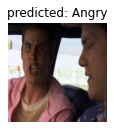

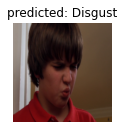

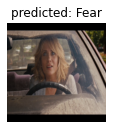

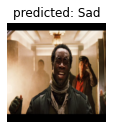

In [ ]:
visualize_model(model_q)
# plt.ioff()
# plt.tight_layout()
# plt.savefig("emotions.jpg")
# #plt.show()

In [ ]:
for param_tensor in model_q.state_dict():
    print(param_tensor, "\t", model_q.state_dict()[param_tensor].size())
    if param_tensor == 'classifier.6.6.weight':
      l = model_q.state_dict()[param_tensor]

0.0.scale 	 torch.Size([1])
0.0.zero_point 	 torch.Size([1])
0.1.weight 	 torch.Size([64, 3, 7, 7])
0.1.scale 	 torch.Size([])
0.1.zero_point 	 torch.Size([])
0.1.bias 	 torch.Size([64])
0.5.0.conv1.weight 	 torch.Size([64, 64, 1, 1])
0.5.0.conv1.scale 	 torch.Size([])
0.5.0.conv1.zero_point 	 torch.Size([])
0.5.0.conv1.bias 	 torch.Size([64])
0.5.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
0.5.0.conv2.scale 	 torch.Size([])
0.5.0.conv2.zero_point 	 torch.Size([])
0.5.0.conv2.bias 	 torch.Size([64])
0.5.0.conv3.weight 	 torch.Size([256, 64, 1, 1])
0.5.0.conv3.scale 	 torch.Size([])
0.5.0.conv3.zero_point 	 torch.Size([])
0.5.0.conv3.bias 	 torch.Size([256])
0.5.0.downsample.0.weight 	 torch.Size([256, 64, 1, 1])
0.5.0.downsample.0.scale 	 torch.Size([])
0.5.0.downsample.0.zero_point 	 torch.Size([])
0.5.0.downsample.0.bias 	 torch.Size([256])
0.5.0.skip_add_relu.scale 	 torch.Size([])
0.5.0.skip_add_relu.zero_point 	 torch.Size([])
0.5.1.conv1.weight 	 torch.Size([64, 256, 1, 1])
0.5.1

In [ ]:
state_dict = model_q.state_dict()
wt  = state_dict['2.1.weight'].cpu().clone().detach().numpy()
# wt1  = state_dict['2.2.weight'].cpu().clone().detach().numpy()
# bs  = state_dict['2.2.bias'].cpu().clone().detach().numpy()

In [ ]:

import pandas as pd
lk = pd.DataFrame(wt)
from sklearn import preprocessing
x = lk.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
lk1 = pd.DataFrame(x_scaled)
lk1 = lk1-0.5
lk1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.500000,0.378382,-0.098078,-0.500000,-0.359911,-0.500000,0.023868,0.500000,-0.361395,-0.146809,0.038601,-0.500000,0.059148,0.500000,-0.387588,-0.402292,0.271118,-0.500000,-0.293780,0.174907,-0.486433,0.241439,0.070202,-0.059301,-0.450715,-0.239282,-0.360630,0.169589,-0.500000,-0.044752,-0.500000,-0.500000,-0.125349,-0.433256,-0.379612,-0.500000,-0.281319,0.010404,-0.500000,0.445139,...,0.500000,-0.300431,0.204897,0.295789,-0.500000,0.085896,-0.136563,-0.500000,-0.500000,0.500000,0.500000,-0.296961,-0.500000,-0.500000,-0.133283,-0.500000,0.101796,0.285809,0.269978,-0.499604,-0.237569,-0.358638,0.062278,-0.418475,-0.274517,0.119021,-0.500000,-0.353133,0.193686,-0.500000,0.300274,-0.409053,-0.292963,0.114722,0.500000,-0.279961,-0.332149,-0.167214,0.013132,-0.349462
1,-0.036812,0.072247,0.112202,-0.217324,0.275722,0.055073,0.500000,0.127524,0.291301,0.033659,-0.287582,0.423206,-0.500000,0.184627,0.500000,0.151434,-0.081658,-0.408429,-0.500000,0.150444,0.311492,-0.055611,0.003608,-0.318710,-0.500000,-0.329292,-0.225188,-0.186295,0.082700,-0.500000,-0.123631,-0.029275,0.230407,-0.500000,-0.182560,-0.352119,0.500000,-0.500000,0.284393,-0.500000,...,-0.500000,-0.130371,-0.021923,0.500000,0.500000,-0.500000,-0.118366,0.096554,-0.366723,-0.031321,-0.145619,-0.108508,-0.346346,-0.382834,-0.321132,0.249604,-0.500000,0.109172,-0.500000,-0.449051,0.035841,0.273712,-0.500000,-0.500000,-0.006644,-0.043100,0.279211,0.000169,0.214309,-0.433335,-0.261951,-0.340728,-0.153613,0.107570,0.289822,-0.304305,-0.465135,0.118023,0.500000,0.500000
2,-0.274571,0.329766,-0.500000,0.215453,-0.500000,0.500000,-0.500000,0.333872,0.500000,-0.121715,-0.500000,0.397799,0.074636,-0.466000,-0.321626,-0.308934,0.048352,-0.300353,-0.238528,-0.500000,0.135567,0.029739,-0.333077,-0.177853,0.185244,-0.157397,-0.402327,0.500000,-0.370503,0.132723,-0.036339,0.500000,-0.380186,-0.186901,0.359813,-0.261181,-0.500000,0.202174,0.029725,0.417322,...,-0.152774,-0.227974,-0.500000,-0.500000,-0.441640,0.500000,0.500000,-0.262002,-0.230421,0.136037,0.483633,0.289203,0.073396,0.500000,0.500000,0.500000,0.285425,0.177178,0.390623,0.081287,0.500000,-0.284429,-0.377179,0.109001,-0.122762,0.421491,-0.430280,0.500000,0.014518,-0.209450,0.500000,0.500000,-0.351563,0.254282,-0.434934,0.413999,-0.135709,-0.159452,-0.058678,0.088278
3,0.351565,-0.238324,0.500000,0.323413,-0.061667,0.093432,0.082183,-0.051259,-0.021323,-0.500000,0.500000,0.234723,0.129803,-0.278673,-0.500000,0.052945,-0.500000,-0.211151,-0.075283,0.107059,0.500000,-0.500000,0.120471,0.124361,-0.132905,-0.500000,0.324013,-0.500000,-0.344565,-0.183133,0.325337,0.306501,0.261340,0.500000,-0.164480,-0.251131,0.061883,0.500000,-0.078136,0.121618,...,-0.460338,0.066599,-0.271589,-0.153644,-0.119048,-0.163191,0.289753,0.300525,0.028514,-0.107753,0.023181,0.100507,0.098399,-0.248568,-0.500000,-0.079518,-0.192974,0.500000,-0.351090,-0.500000,-0.500000,0.409613,0.010584,-0.157066,-0.420664,0.500000,0.177244,-0.047342,-0.500000,0.199273,-0.097224,0.357149,-0.383627,-0.500000,-0.500000,-0.500000,-0.488969,0.145892,-0.500000,-0.368813
4,-0.158773,0.500000,-0.219942,0.500000,-0.182897,0.090888,0.267751,-0.500000,-0.194079,0.500000,-0.104368,0.023072,0.500000,-0.500000,0.284027,0.500000,0.315223,0.059302,-0.383662,0.500000,0.374579,-0.240306,-0.139317,0.500000,-0.137138,0.206657,0.500000,-0.144685,0.155510,0.220978,0.116283,0.163703,0.500000,-0.181050,0.500000,0.500000,0.109476,-0.095451,0.500000,-0.201161,...,0.034229,0.200063,-0.064808,-0.056935,-0.470418,-0.130092,-0.092339,0.500000,0.500000,-0.161894,0.449990,-0.233786,0.151053,0.409468,0.285083,0.240567,-0.344933,0.165087,-0.163015,0.500000,-0.066598,-0.310071,-0.348420,0.

In [ ]:
l = [] 
cos_vec =[]
import math
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm
from scipy.spatial.distance import cosine
from itertools import combinations
#for number of hidden neurons arranging and calculating the angle
l = list(combinations(np.arange(0,100),2))

for i in l:
    u = lk1[i[0]]
    v = lk1[i[1]]
    c = dot(u,v)/norm(u)/norm(v) 
    angle = math.degrees(arccos(c))
    cos_vec.append([angle,i])
#finding the similar and comp indices
similar_indices=[]
Comp_indices=[]
for i in cos_vec:
    #threshold is given as in paper
    if i[0] <20:
        similar_indices.append(i[1])
    elif i[0] >160:
        Comp_indices.append(i[1])

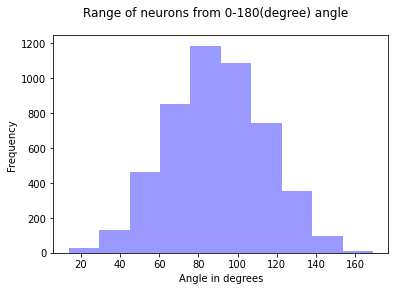

In [ ]:
hist = []
for k in cos_vec:
  hist.append(k[0])
num_bins = 10
n, bins, patches = plt.hist(hist, num_bins, facecolor='blue', alpha=0.4)
plt.suptitle('Range of neurons from 0-180(degree) angle')
plt.xlabel('Angle in degrees')
plt.ylabel('Frequency')
plt.savefig('100.png')
plt.show()

In [ ]:
x=np.array(Comp_indices)
c = np.unique(x)
deletion =list(c)
l = []
for j in deletion:
    for i in range(len(similar_indices)):
        if j in similar_indices[i]:
            l.append(similar_indices[i])
mylist = list(dict.fromkeys(l))

In [ ]:
sim = list(set(similar_indices) - set(mylist))
print(len(deletion))
print(len(sim))

1370
217


In [ ]:
for k in sim:
    wt[:,k[0]] = wt[:,k[0]] + wt[:,k[1]]
    wt[:,k[1]] = float(0) 

In [ ]:
for j in deletion:
    wt[:,j] = float(0)    

In [ ]:
model_q.state_dict()['2.1.weight'].data.copy_(torch.tensor(wt))
model_q.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(7)]
    n_class_samples = [0 for i in range(7)]
    for images, labels in dataloaders['test']:
        images = images.cpu()
        labels = labels.cpu()
        outputs = model_q(images)
        # max returns (value ,index)
        _, predicted = torch.max((outputs),1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 54.411764705882355 %
